## **Customer Segmentation by RFM model and K-Means with AWS SageMaker AI**

This lab demonstrates customer segmentation analysis using the RFM (Recency, Frequency, Monetary) model combined with K-Means clustering. Participants will analyze customer purchase behavior data from a cosmetics retailer to identify distinct customer segments for targeted marketing strategies.

### **Step 1: Import modules**

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()

### **Step 2: Data Integration**

The dataset comprises customer transaction records collected over a 5-month period from October 2019 to February 2020, with each file representing one month of data. 

This step loads and combines multiple CSV files from AWS S3, adds month identifiers, and creates a unified dataset for subsequent analysis.

In [2]:
# Import boto3 to work with AWS S3
import boto3
from io import StringIO

s3_client = boto3.client('s3')

bucket_name = 'lab-aws-workshop'  
s3_prefix = 'input_data/'  

def load_csv_files_from_s3(bucket, prefix):
    """
    Load CSV data from S3 folder
    
    Parameters:
    bucket (str): S3 bucket name
    prefix (str): Folder path in S3
    
    Returns:
    pd.DataFrame: Combined dataframe
    """
    # list all files in S3 folder
    response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
    
    frame = []
    
    if 'Contents' not in response:
        print(f"No files found in {bucket}/{prefix}")
        return None
    
    for obj in response.get('Contents', []):
        file_key = obj['Key']
        
        if file_key.endswith('.csv'):
            print(f"Loading {file_key}...")
            
            try:
                obj_data = s3_client.get_object(Bucket=bucket, Key=file_key)
                df_i = pd.read_csv(obj_data['Body'])
                
                month = file_key.split('-')[-1].replace('.csv', '')
                df_i['month'] = month
                
                frame.append(df_i)
                print(f"  ✓ Loaded successfully: {len(df_i)} rows")
                
            except Exception as e:
                print(f"  ✗ Error loading {file_key}: {e}")
                continue
    
    if not frame:
        print("No CSV files were loaded!")
        return None
    
    # Combine all dataframes
    df = pd.concat(frame, ignore_index=True, sort=False)
    return df

print("Loading data from S3...")
df = load_csv_files_from_s3(bucket_name, s3_prefix)

# a quick examination of the dataframe
print("The dataframe has {} rows and {} columns.\n".format(df.shape[0],df.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
display(df.head(3))

Loading data from S3...
Loading input_data/2019-Dec.csv...
  ✓ Loaded successfully: 3533286 rows
Loading input_data/2019-Nov.csv...
  ✓ Loaded successfully: 4635837 rows
Loading input_data/2019-Oct.csv...
  ✓ Loaded successfully: 4102283 rows
Loading input_data/2020-Feb.csv...
  ✓ Loaded successfully: 4156682 rows
Loading input_data/2020-Jan.csv...
  ✓ Loaded successfully: 4264752 rows
The dataframe has 20692840 rows and 10 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,Dec
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,Dec
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,Dec


### **Step 3: Data preparation**

RFM analysis is a widely-used customer segmentation technique based on three metrics: 
- 1. Recency (time since last purchase)
- 2. Frequency (number of purchases)
- 3. Monetary Value (total spending) <br> 

The following preprocessing steps prepare the data for clustering analysis: selection of relevant purchase events, removal of non-essential columns, elimination of duplicate records, and data type conversion.

In [19]:
# select customers who purchased
df_sales=df.loc[df.event_type=='purchase',:]

# drop "category_code", "brand", "product_id", "category_id", and "user_session"
df_sales=df_sales.drop(columns=['category_code','brand','product_id','category_id','user_session'])

# drop duplicates
df_sales=df_sales.drop_duplicates()

# convert "event_time" to DateTime format
df_sales['event_time']=pd.to_datetime(df_sales['event_time'])

nullcolumns=df_sales.isnull().sum()
nullnumbers=len(nullcolumns[nullcolumns!=0])
print("After data selection and cleansing, the dataframe has {} rows, {} columns, and {} null value.\n".format(df_sales.shape[0],df_sales.shape[1],nullnumbers))
print("Shown below are the first 3 rows of the cleaned dataframe:\n")
display(df_sales.head(3))

After data selection and cleansing, the dataframe has 908776 rows, 5 columns, and 0 null value.

Shown below are the first 3 rows of the cleaned dataframe:



,event_time,event_type,price,user_id,month
557,2019-12-01 00:17:50+00:00,purchase,0.38,473613801,Dec
560,2019-12-01 00:17:50+00:00,purchase,0.37,473613801,Dec
565,2019-12-01 00:17:50+00:00,purchase,0.41,473613801,Dec


### **Step 4**: **Data exploration**<br>

Time series analysis of the dataset reveals the following patterns:

1. **Customer Volume**: Customer activity peaked in November 2019 and late January 2020, with a notable decline on New Year's Eve, suggesting seasonal trends and potential system availability impacts.

2. **Sales Revenue**: Monthly sales increased from approximately $0.95 million (October 2019) to $1.3 million (November 2019), declined to $0.85 million (December 2019), and stabilized around $1 million for the subsequent two months.

3. **Average Customer Spend**: Average spending per customer remained relatively stable across all five months of the analysis period.

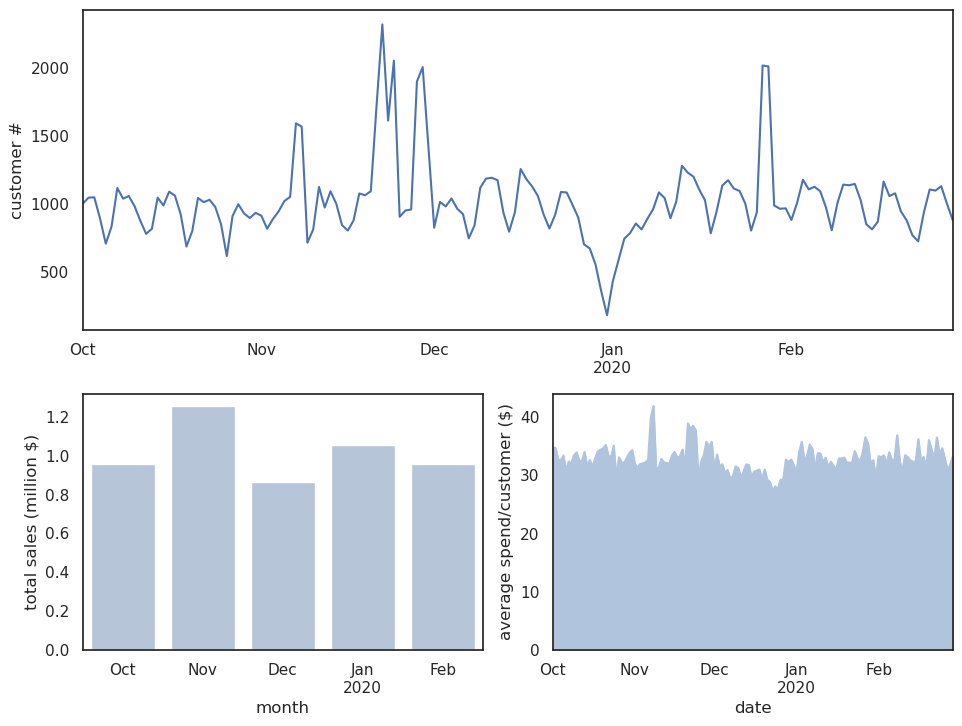

In [20]:
# initial data exploration

plt.figure(figsize=(10,8))

# plot the number of customers each day 
plt.axes([0.08, 0.4, 0.87, 0.4])
df_sales_n_user=df_sales.resample("D",on='event_time')['user_id'].nunique()
df_sales_n_user.plot(kind='line')
plt.xlabel('')
plt.ylabel('customer #')

# plot total sales/month 
plt.axes([0.08,0,0.4,0.32])
a=df_sales.resample('ME',on='event_time')['price'].sum().to_frame()
a['month']=['Oct','Nov','Dec',"Jan\n2020", "Feb"]
a['price']=a['price']/1000000
sns.barplot(x='month',y='price',data=a,color="lightsteelblue")
plt.xlabel('month')
plt.ylabel('total sales (million $)')

# plot average spend/customer
plt.axes([0.55,0,0.4,0.32])
df_sales_p_day=df_sales.resample('D',on='event_time')['price'].sum()
df_sales_spent=df_sales_p_day/df_sales_n_user
df_sales_spent.plot(kind='area',color="lightsteelblue")
plt.xlabel('date')
plt.ylabel('average spend/customer ($)');

### **Step 5: Caculate RFM score**

The analysis aggregates transaction data by customer to calculate three key RFM metrics for each individual: 
- 1. Recency (months since last purchase relative to February 2020).
- 2. Frequency (number of purchases from October 2019 to February 2020).
- 3. Monetary Value (total spending over the analysis period).<br>

Outliers are identified and removed using **Z-score** analysis (threshold: ±3 standard deviations) to improve clustering quality.

In [43]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
d={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}
df_sales.loc[:,'Recency']=df_sales['month'].map(d)
df_R=df_sales.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})

# step 2: calculate "Frequency"
df_F=df_sales.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})

# step 3: calculate "Monetary"
df_M=df_sales.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})

# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')

# step 5: remove outliers before K-Means clustering
#  Loại bỏ Outliers (Ngoại lệ) bằng Z-score
# Z-score = (giá trị - mean) / std
conditions=np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_RFM2=df_RFM.loc[conditions,:]

df_RFM2.head(5)

,user_id,Recency,Frequency,Monetary
0,9794320,3,2,7.72
1,10079204,3,2,25.81
2,10280338,0,19,63.29
3,12055855,2,4,16.54
4,12936739,1,2,29.89


Exploratory analysis of the RFM metrics shows the following distributions: 

- (1) Customers are distributed relatively uniformly across the recency spectrum; 

- (2) The majority of customers made fewer than 10 purchases; 

- (3) Most customers spent less than $100 across the five-month period.

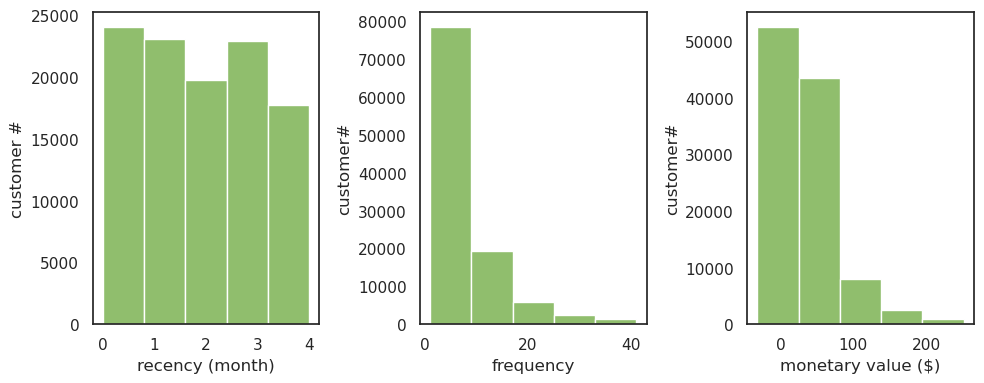

In [74]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,4))

# plot "Recency"
ax1.hist(df_RFM2['Recency'],bins=5,color='#90BE6D')
ax1.set_xticks(np.arange(0,5,1))
ax1.set_xlabel('recency (month)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM2['Frequency'],bins=5,color='#90BE6D')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM2['Monetary'],bins=5,color='#90BE6D')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()

### **Step 5: Customer Segmentation by RFM-Based K-Means Clustering**

Rather than using discrete RFM scores, this analysis employs K-Means clustering directly on the RFM metrics to identify natural customer segments. 

The optimal number of clusters is determined using the **Elbow method**, followed by data standardization prior to clustering.

*Look for the point on the graph where the line bends sharply, resembling an elbow. This is the point where the rate of decrease in WCSS (WCSS is the sum of the squared distances between each data point and its assigned cluster's centroid.) slows down significantly.*

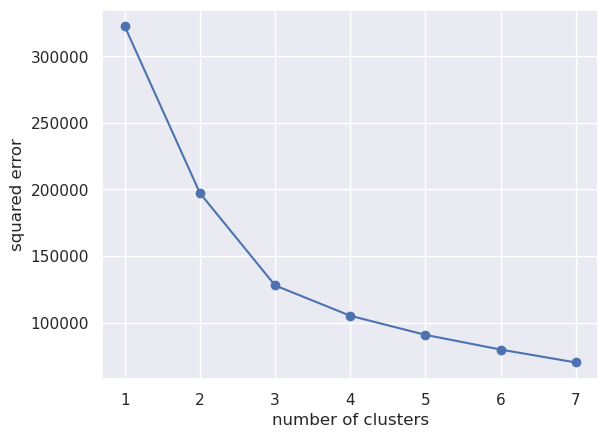

In [45]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 1: standardize data
df_RFM3=df_RFM2.drop(columns=['user_id'])
X = StandardScaler().fit_transform(df_RFM3)

# step 2: find the optimal number of clusters
SSE=[]
for i in range(1,8,1):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)
sns.set()
plt.plot(range(1,8,1),SSE,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('squared error');

In [54]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 3: group customers into 4 clusters
random.seed(8)
km=KMeans(n_clusters=4,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)
# replace k-means cluster names with more meaningful names
d1={0:"Segment A", 1:"Segment B", 2: "Segment C", 3:"Segment D"}
df_RFM2.loc[:,"segments"]=df_RFM2.loc[:,"clusters"].map(d1)

display(df_RFM2.head(5))

,user_id,Recency,Frequency,Monetary,clusters,segments
0,9794320,3,2,7.72,1,Segment B
1,10079204,3,2,25.81,1,Segment B
2,10280338,0,19,63.29,0,Segment A
3,12055855,2,4,16.54,2,Segment C
4,12936739,1,2,29.89,3,Segment D


**Customer Segment Definitions**

The K-Means clustering algorithm identifies four distinct customer segments based on RFM metrics:

- **Loyal Customers**: High purchase frequency and monetary value; recent transaction history

- **Potential Loyalists**: Moderate purchase frequency and spending; growth opportunity segment

- **New Customers**: Recent market entry; low frequency and monetary value; development potential

- **At-Risk Customers**: High time since last purchase; low engagement and spending; retention focus

In [55]:
# step 4: visualize the 4 clusters

# calculate the number of customers, median recency, median frequency, 
# and average customer spend in each customer segment
df_RFM3=df_RFM2.groupby('segments').agg(Recency=('Recency','median'),Frequency=('Frequency','median'),MonetarySum=('Monetary','sum'),size=("segments",'size'))
df_RFM3.loc[:,'Sales/Customer']=round(df_RFM3.loc[:,'MonetarySum']/df_RFM3.loc[:,'size'])
df_RFM3=df_RFM3.astype({'Sales/Customer':int}).reset_index()

# Show output of dataframe
display(df_RFM3)

,segments,Recency,Frequency,MonetarySum,size,Sales/Customer
0,Segment A,1.0,20.0,1433076.77,12150,118
1,Segment B,4.0,3.0,596172.82,28668,21
2,Segment C,2.0,6.0,1066818.16,29048,37
3,Segment D,0.0,4.0,1012287.22,37640,27


/tmp/ipykernel_4577/975253211.py:11: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(x='number of customers',y='segments',hue='segments',data=seg,order=seg_names,palette=mycolors,legend=False)
/tmp/ipykernel_4577/975253211.py:22: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM3)


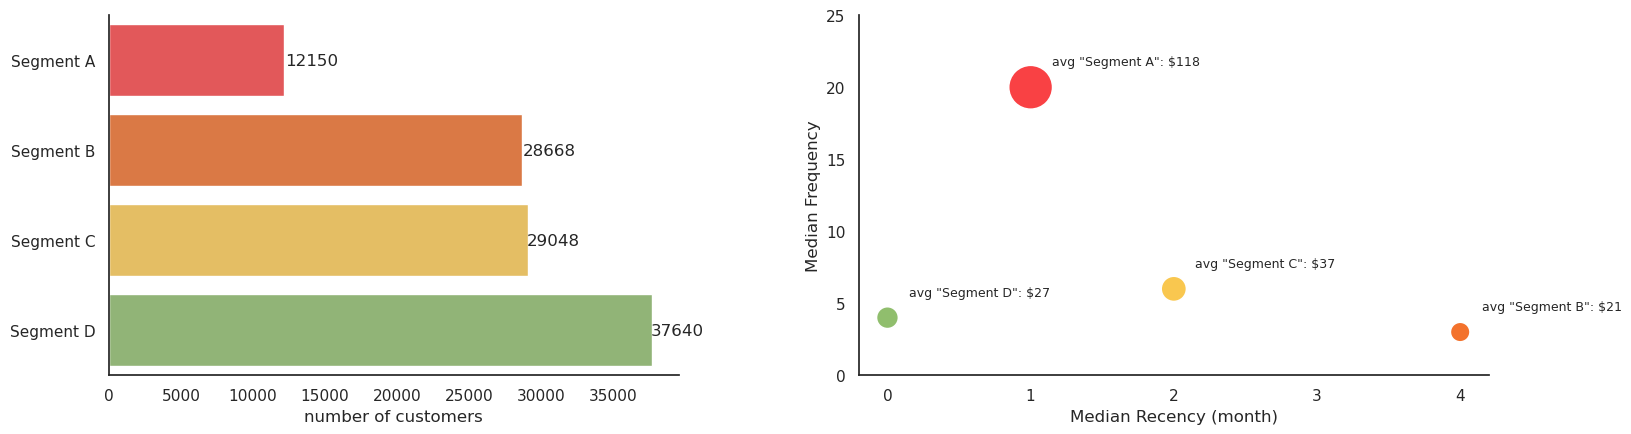

In [75]:
# visualize
mycolors=['#F94144', '#F3722C', '#F9C74F', '#90BE6D', '#43AA8B', '#577590']

plt.figure(figsize=(15,4))
seg_names=["Segment A","Segment B","Segment C","Segment D"]

# plot the number of customers in each segment
sns.set_style("white")
ax = plt.axes([0, 0, 0.38, 0.9])
seg=df_RFM2.groupby('segments').size().to_frame(name='number of customers').reset_index()
sns.barplot(x='number of customers',y='segments',hue='segments',data=seg,order=seg_names,palette=mycolors,legend=False)
for i, seg_name in enumerate(seg_names):
    number = int(seg.loc[seg['segments'] == seg_name, 'number of customers'].values[0])
    x_pos=round(number,-2)
    ax.text(x_pos, i, number, va='center')
ax.set_ylabel("")
sns.despine()
# plt.show()

# plot recency, frequency, and average spend/customer of the 4 segments
plt.axes([0.5,0,0.42,0.9])
sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM3)
plt.ylim(0,25)
plt.xticks(list(range(5)))
for idx, row in df_RFM3.iterrows():
    x = row['Recency']
    y = row['Frequency']
    segment = row['segments']
    sales = row['Sales/Customer']

    # Dịch chuyển text để tránh chồng lập
    offset_x = 0.15
    offset_y = 1.5

    if segment == "Loyal Customers":
        offset_x = 0.25
        offset_y = 2.5
    elif segment == "At-Risk":
        offset_x = 0.25
        offset_y = -2
    elif segment == "New Customers":
        offset_x = -0.35
        offset_y = -1.5
    elif segment == "Potential Loyalist":
        offset_x = 0.15
        offset_y = 1

    label_text = f'avg "{segment}": ${sales}'
    plt.text(x + offset_x, y + offset_y, label_text, fontsize=9, ha='left')

plt.xlabel('Median Recency (month)')
plt.ylabel('Median Frequency')
sns.despine()

In [10]:
df_segments = pd.DataFrame(
    {'segments':['Loyal Customers','Potential Loyalist','New Customers','At-Risk'],
    'definition':['These customers purchased very often and spent the highest amount of money.',
                 'This group shopped quite often (though not as frequent as the loyal customers) and spent reasonable amount of money (though not as high as the loyal customers)',
                 'They started shopping very recently and as a result, they didn’t make purchases often nor spend much money',
                 'These customers have high recency, low frequency, and low monetary'
                 ]
     })
df_RFM3 = pd.merge(df_RFM2, df_segments, on = 'segments', how = 'left')
display(df_RFM3.head(3))

,user_id,Recency,Frequency,Monetary,clusters,segments,definition
0,9794320,3,2,7.72,1,At-Risk,"These customers have high recency, low frequen..."
1,10079204,3,2,25.81,1,At-Risk,"These customers have high recency, low frequen..."
2,10280338,0,19,63.29,0,New Customers,They started shopping very recently and as a r...


### **Step 6: Save results to S3 bucket**

In [11]:
# Save results to S3 bucket
def save_dataframe_to_s3(df, bucket, folder, file_name):
    """
    Ghi DataFrame vào S3 folder cụ thể
    
    Parameters:
    df (pd.DataFrame): DataFrame cần lưu
    bucket (str): S3 bucket name
    folder (str): Folder path (vd: 'output_data/')
    file_name (str): Tên file (vd: 'rfm_scores.csv')
    """
    try:
        key = f"{folder}{file_name}"
        
        # convert DataFrame to CSV string
        csv_buffer = StringIO()
        df.to_csv(csv_buffer, index=False)
        
        # wirte to S3
        s3_client.put_object(
            Bucket=bucket,
            Key=key,
            Body=csv_buffer.getvalue()
        )
        
        print(f"✅ Successfully saved to s3://{bucket}/{key}")
        print(f"   Rows: {len(df)}, Columns: {len(df.columns)}")
        return True
        
    except Exception as e:
        print(f"❌ Error saving to S3: {e}")
        return False

save_dataframe_to_s3(df_RFM3, 'lab-aws-workshop', 'output_data/','customer_segmentation.csv')

✅ Successfully saved to s3://lab-aws-workshop/output_data/customer_segmentation.csv
   Rows: 107506, Columns: 7


True

In [12]:
import os, sys, json
import boto3
from botocore.config import Config

AWS_REGION = os.getenv("AWS_REGION", "us-east-1")  # change if needed

bedrock_runtime = boto3.client(
    "bedrock-runtime",
    region_name=AWS_REGION,
    config=Config(retries={"max_attempts": 10, "mode": "standard"})
)

print("Bedrock Runtime ready in region:", AWS_REGION)

Bedrock Runtime ready in region: us-east-1


In [14]:
bedrock = boto3.client("bedrock", region_name=AWS_REGION)

# This returns models visible in your account/region.
catalog = bedrock.list_foundation_models()
available = [
    {"modelId": m["modelId"], "provider": m.get("providerName"), "inputModalities": m.get("inputModalities")}
    for m in catalog.get("modelSummaries", [])
]
len(available), available[:5]


(105,
 [{'modelId': 'stability.stable-fast-upscale-v1:0',
   'provider': 'Stability AI',
   'inputModalities': ['TEXT', 'IMAGE']},
  {'modelId': 'anthropic.claude-sonnet-4-20250514-v1:0',
   'provider': 'Anthropic',
   'inputModalities': ['TEXT', 'IMAGE']},
  {'modelId': 'anthropic.claude-haiku-4-5-20251001-v1:0',
   'provider': 'Anthropic',
   'inputModalities': ['TEXT', 'IMAGE']},
  {'modelId': 'stability.stable-image-erase-object-v1:0',
   'provider': 'Stability AI',
   'inputModalities': ['TEXT', 'IMAGE']},
  {'modelId': 'stability.stable-image-control-structure-v1:0',
   'provider': 'Stability AI',
   'inputModalities': ['TEXT', 'IMAGE']}])

In [18]:
model_id = "amazon.nova-micro-v1:0"  # change to a model you have access to
prompt = """
You are a data analyst specializing in customer segmentation using RFM metrics (Recency, Frequency, Monetary).

Below is a summary table of customer segments generated by a K-means clustering algorithm.  
Each segment has the median Recency (days since last purchase), median Frequency (number of purchases), total Monetary value, number of customers, and average Sales per Customer (Sales_Customer_Ratio).

Please:
1. Analyze the behavioral characteristics of each segment based on RFM values.
2. Assign a meaningful segment name (e.g., "High-Value Loyal Customers", "At-Risk Customers", "New Engaged Customers", etc.).
3. Provide a short but detailed description for each segment, explaining their purchase behavior and value to the business.
4. Return the result in a clean markdown table with columns: Segment_Id | Segment_Name | Description.

Here is the data:

Segment_Id | Median_Recency | Median_Frequency | Monetary | Num_Of_Size | Sales_Customer_Ratio
0 | 4.0 | 3.0 | 596172.82 | 28668 | 21
1 | 0.0 | 4.0 | 1012287.22 | 37640 | 27
2 | 1.0 | 20.0 | 1433076.77 | 12150 | 118
3 | 2.0 | 6.0 | 1066818.16 | 29048 | 37
"""

response = bedrock_runtime.converse(
    modelId=model_id,
    messages=[{"role": "user", "content": [{"text": prompt}]}],
    inferenceConfig={"maxTokens": 800, "temperature": 0.3, "topP": 0.9},
)

result = "".join(
    c.get("text", "") for c in response["output"]["message"]["content"] if "text" in c
)
print(result)


Here's the analysis of the customer segments based on the provided RFM metrics:

### Segment Analysis

1. **Segment 0: "Low-Engagement Customers"**
   - **Description**: These customers have a relatively low frequency of purchases (3 times) and a median recency of 4 days, indicating they are not very active. However, they do generate a decent monetary value per customer, though not the highest. They represent a small segment of the overall customer base (28,668 customers) with an average sales per customer ratio of $21.

2. **Segment 1: "High-Value New Customers"**
   - **Description**: This segment consists of customers who have made their first purchase very recently (median recency of 0 days) and have a high purchase frequency (4 times). They also have a high monetary value per customer, indicating they bring significant revenue. This segment is large (37,640 customers) and has an average sales per customer ratio of $27, suggesting these customers are both new and valuable.

3. **Se